# MaxCut - QAOA
I aim to solve the MaxCut problem on a graph using a QAOA ansatz as described in [https://arxiv.org/abs/1411.4028](https://arxiv.org/abs/1411.4028) 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import time

# Import the Qiskit SDK
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, Aer

from qiskit.tools.visualization import matplotlib_circuit_drawer as drawer, qx_color_scheme

In [2]:
# number of vertices in the graph, the vertices are labelled from 0 to graph_size - 1
graph_size = 4
# list of edges [i,j] implies an edge between vertex i and vertex j
# this is simply a ring with vertices
edges = [[0,1],[1,2],[2,3],[3,0]]

## Circuit diagram 
Note that the drawer places measurement gates in betweent the circuit (as opposed to the end). This does not affect computation.

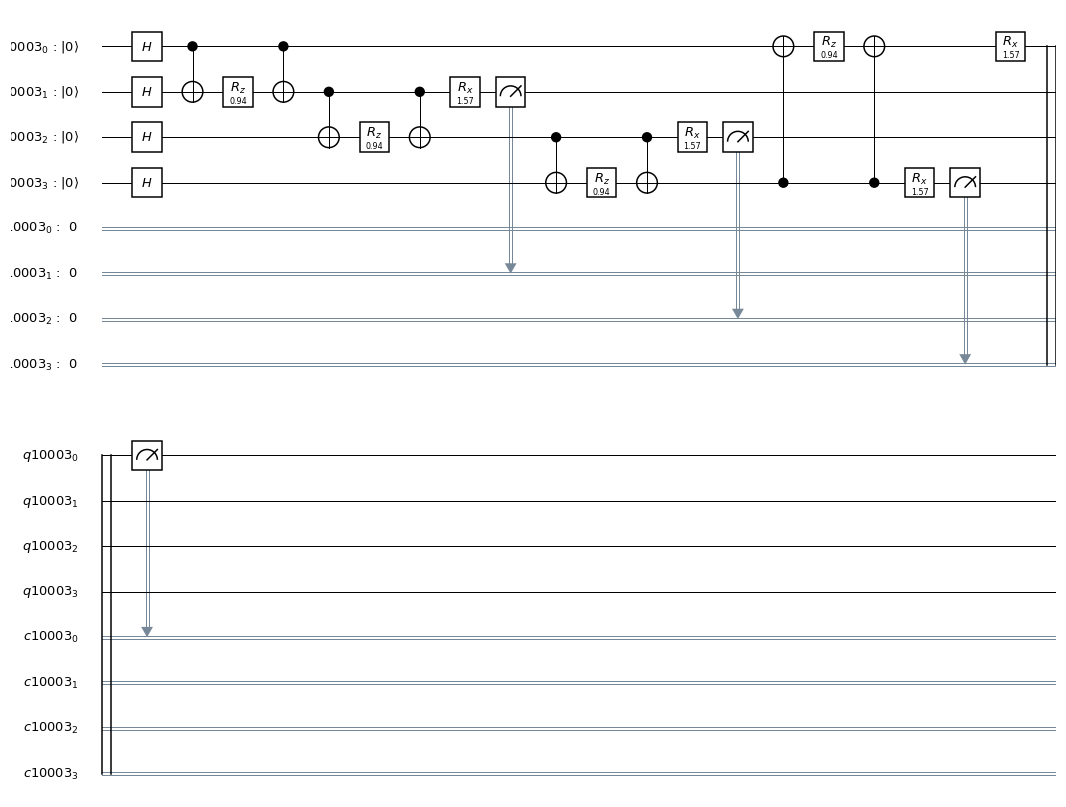

In [22]:
# QAOA parameters
# normalized in units of pi
beta = 0.5
gamma = 0.3


q = QuantumRegister(graph_size) 
c = ClassicalRegister(graph_size)

qc = QuantumCircuit(q,c)

# Hadamard Layer
for i in range(graph_size):
    qc.h(q[i])

# U(C,gamma) layer
for (i,j) in edges:
    qc.cx(q[i],q[j])
    qc.rz(gamma*np.pi,q[j])
    qc.cx(q[i],q[j])
    
# U(B,beta layer)
for i in range(graph_size):
    qc.rx(beta*np.pi,q[i])
    
qc.measure(q, c)
drawer(qc)

In [37]:
# Choose a simulator. I used the default qasm simulator. 
num_shots = 1000
backend_sim = Aer.get_backend('qasm_simulator')
job_sim = execute(qc, backend_sim,shots=num_shots)
result_sim = job_sim.result()

res = result_sim.get_counts(qc)


In [38]:
print(res)

{'0000': 115, '0001': 58, '0010': 54, '0011': 3, '0100': 67, '0101': 128, '0110': 5, '0111': 44, '1000': 55, '1001': 6, '1010': 133, '1011': 78, '1100': 6, '1101': 64, '1110': 63, '1111': 121}


In [50]:
def calc_C_avg(res):
    '''
        res is the dictionary of results from the simulator
    '''
    C_avg = 0
    num_items = 0
    
    def convert(key):
        '''
        Change from 0,1 to -1,1:
        '''
        num_key = np.array(list(key),dtype=np.int32)
        return 1 - 2*num_key
    
    for key,item in res.items():
        C = 0
        for (i,j) in edges:
            num_key = convert(key)
            C += 0.5*(-num_key[i]*num_key[j] + 1)  
        C_avg += C*item
        num_items += item
    C_avg /= num_items
    return C_avg

In [51]:
# test
print("C average",calc_C_avg(res))

C average 2.05


## QAOA simulator function

In [56]:
# QAOA anstatz as a funtion of beta and gamma
# put everything together
def calc_qaoa_C(beta,gamma,num_shots=100):
    '''
        Returns C_avg calculated as a function of beta and gamma
    '''
    q = QuantumRegister(graph_size) 
    c = ClassicalRegister(graph_size)

    qc = QuantumCircuit(q,c)

    # Hadamard Layer
    for i in range(graph_size):
        qc.h(q[i])

    # U(C,gamma) layer
    for (i,j) in edges:
        qc.cx(q[i],q[j])
        qc.rz(gamma*np.pi,q[j])
        qc.cx(q[i],q[j])

    # U(B,beta layer)
    for i in range(graph_size):
        qc.rx(beta*np.pi,q[i])

    qc.measure(q, c)
    
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = execute(qc, backend_sim,shots=num_shots)
    result_sim = job_sim.result()

    res = result_sim.get_counts(qc)
    
    return calc_C_avg(res)
    
    

# Discrete Sweep over $\gamma,\beta$ values

In [57]:
# manual sweep over beta,gamma values

# num_shots : number of measurements
num_shots = 100

# manual sweep
num_points = 100
beta_linspace = np.linspace(0,1,num_points)
gamma_linspace = np.linspace(0,2,num_points)
C_arr = []
st = time.time()
for beta in beta_linspace:
    for gamma in gamma_linspace:
        C_arr.append(calc_qaoa_C(beta,gamma,num_shots))
print("Completed in ",time.time()-st)

Completed in  3098.8761110305786


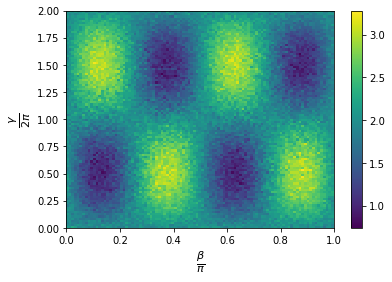

In [60]:
C_arr = np.array(C_arr).reshape(num_points,num_points)
XX,YY = np.meshgrid(beta_linspace,gamma_linspace)
plt.pcolor(XX,YY,C_arr)
plt.xlabel(r"$\frac{\beta}{\pi}$",fontsize=16)
plt.ylabel(r"$\frac{\gamma}{2\pi}$",fontsize=16)
plt.colorbar()

In [61]:
print("Max. estimated value of C",np.max(C_arr))

Max. estimated value of C 3.28


# Notes
The exact maximum value of C is 4 for the ring graph on 4 vertices (adjacent vertices have opposite values). The QAOA ansatz with 2 angles achives optimal values close to 3.3.

This accuracy can be potentially improved by increasing the number of parametric angles.